## smoothing preproc images using nipype

In [1]:
from os.path import join as opj
import os
import json
from nipype.interfaces.fsl import (BET, ExtractROI, FAST, FLIRT, ImageMaths,ApplyMask,
                                   MCFLIRT, SliceTimer, Threshold, IsotropicSmooth)
from nipype.interfaces.spm import Smooth, SliceTiming
from nipype.interfaces.utility import IdentityInterface
from nipype.interfaces.io import SelectFiles, DataSink
from nipype.algorithms.rapidart import ArtifactDetect
from nipype import Workflow, Node

201005-10:10:28,543 nipype.utils WARNING:
	 A newer version (1.5.1) of nipy/nipype is available. You are using 1.5.0-rc1.post-dev


### check TR

In [2]:
import numpy as np
import nibabel as nib

In [3]:
func_img = nib.load('/data/sub-06/func/sub-06_task-tsl_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz')
header = func_img.header
header.get_zooms()

(2.4, 2.4, 3.12, 2.0)

image spatial voxel sizes (2.4 x 2.4 x 3.12)mm, TR=2s

In [4]:
print(header.get_data_shape())

(81, 96, 63, 246)


shape of image array 246 vols

In [5]:
func_img.shape[2]

63

### check mask

In [8]:
mask_img = nib.load('/data/sub-06/func/sub-06_task-tsl_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz')
header = mask_img.header
header.get_zooms()

(2.4, 2.4, 3.12)

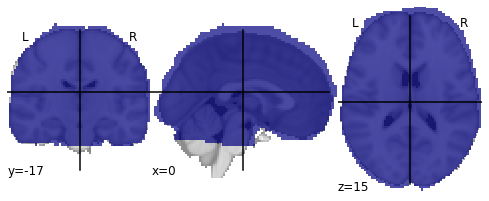

In [9]:
import nilearn.plotting
nilearn.plotting.plot_roi(mask_img)

### nipype smoothing workflow

In [6]:
experiment_dir = '/output'
output_dir = 'smooth'
working_dir = 'workingdir'
data_dir = '/data'

# TR of functional images
TR = 2.

In [7]:
# ExtractROI - skip dummy scans
extract = Node(ExtractROI(t_min=4, t_size=-1, output_type='NIFTI'),
               name="extract")

# Smooth - image smoothing
smooth = Node(Smooth(fwhm=[8,8,8]), name="smooth")
# smooth = Node(IsotropicSmooth(fwhm=4), name='smooth')

### slice time correction

based on [auto detection script](https://en.wikibooks.org/wiki/SPM/Slice_Timing#cite_note-crnl-autodetect-script2-7), the data has Slice order=1, slices=31, TR= 2.000sec, TA= 1.935484sec, referenced to 1st slice. Slice indices [1,2,3...31].

fmriprep output seem to have 63 slices instead.

In [6]:
# slice time correction
from nipype.interfaces.spm import SliceTiming
slice_order = list(range(1, 32, 1))
print(slice_order)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]


In [7]:
slicetime = Node(SliceTiming(num_slices=31,
                             ref_slice=1,
                             slice_order=slice_order,
                             time_repetition=2.,
                             time_acquisition=2.-(2./31)),
                 name='slicetime')

### specify input/output

In [8]:
sj_ls = []
for f in os.listdir('/data/'):
    if f.endswith('.html'):
#         print(f)
        sj_ls.append(f[4:6])
print(sj_ls)
print(len(sj_ls))

['36', '43', '09', '16', '19', '33', '08', '32', '21', '42', '31', '17', '07', '14', '23', '13', '15', '44', '18', '37', '28', '29', '24', '26', '41', '20', '06', '27', '30', '38', '11', '25', '10', '22', '39']
35


without subject 29, there are 155 sessions in total. There are 3 sessions in subject 29.

In [9]:
# crashed within subject 29, remaining runs other than 3-4
sj_ls.remove('29')

In [10]:
print(len(sj_ls))

34


### debug subject 29

In [9]:
!tree /output/smooth

/output/smooth
└── preproc
    ├── sub-06
    │   ├── sub-06_task-tsl_run-1_fwhm-8_bold.nii
    │   ├── sub-06_task-tsl_run-2_fwhm-8_bold.nii
    │   ├── sub-06_task-tsl_run-3_fwhm-8_bold.nii
    │   ├── sub-06_task-tsl_run-4_fwhm-8_bold.nii
    │   └── sub-06_task-tsl_run-5_fwhm-8_bold.nii
    ├── sub-07
    │   ├── sub-07_task-tsl_run-1_fwhm-8_bold.nii
    │   ├── sub-07_task-tsl_run-2_fwhm-8_bold.nii
    │   ├── sub-07_task-tsl_run-3_fwhm-8_bold.nii
    │   ├── sub-07_task-tsl_run-4_fwhm-8_bold.nii
    │   └── sub-07_task-tsl_run-5_fwhm-8_bold.nii
    ├── sub-08
    │   ├── sub-08_task-tsl_run-1_fwhm-8_bold.nii
    │   ├── sub-08_task-tsl_run-2_fwhm-8_bold.nii
    │   ├── sub-08_task-tsl_run-3_fwhm-8_bold.nii
    │   ├── sub-08_task-tsl_run-4_fwhm-8_bold.nii
    │   └── sub-08_task-tsl_run-5_fwhm-8_bold.nii
    ├── sub-09
    │   ├── sub-09_task-tsl_run-1_fwhm-8_bold.nii
    │   ├── sub-09_task-tsl_run-2_fwhm-8_bold.nii
    │   ├── sub-09_task-tsl_run-3_fwhm-8_bold.nii
    │   ├── s

In [30]:
f_total = 0
# for sj in sj_ls:
for sj in ['29']:
    for f in os.listdir('/data/sub-'+sj+'/func'):
        if f.endswith('bold.nii.gz'):
            print(f)
            f_total+= 1
#     print(f'subject %s has %s sessions.' % (sj, fl))
print(f_total)

sub-29_task-tsl_run-3_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
sub-29_task-tsl_run-4_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
sub-29_task-tsl_run-2_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
3


investigate problems with subject 29

In [31]:
for sess in [2,3,4]:    
    func_img = nib.load('/data/sub-29/func/sub-29_task-tsl_run-'+str(sess)+'_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz')

    header = func_img.header
    print('voxel info: ', header.get_zooms())
    print('data shape: ', header.get_data_shape())

voxel info:  (2.4, 2.4, 3.12, 2.0)
data shape:  (81, 96, 63, 2)
voxel info:  (2.4, 2.4, 3.12, 2.0)
data shape:  (81, 96, 63, 246)
voxel info:  (2.4, 2.4, 3.12, 2.0)
data shape:  (81, 96, 63, 246)


exclude session 2 in subject 29.

In [20]:
# sort subjects according to 
for sj in ['29']:
    fl = ['3','4']
    # run
    preproc = define_workflow([sj], fl, experiment_dir, output_dir)
    preproc.run('MultiProc', plugin_args={'n_procs': 4})

201005-09:57:09,65 nipype.workflow INFO:
	 Workflow preproc settings: ['check', 'execution', 'logging', 'monitoring']
201005-09:57:09,93 nipype.workflow INFO:
	 Running in parallel.
201005-09:57:09,101 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 2 jobs ready. Free memory (GB): 14.07/14.07, Free processors: 4/4.
201005-09:57:09,233 nipype.workflow INFO:
	 [Node] Setting-up "preproc.selectfiles" in "/output/workingdir/preproc/_run_num_4_subject_id_29/selectfiles".201005-09:57:09,234 nipype.workflow INFO:
	 [Node] Setting-up "preproc.selectfiles" in "/output/workingdir/preproc/_run_num_3_subject_id_29/selectfiles".

201005-09:57:09,246 nipype.workflow INFO:
	 [Node] Running "selectfiles" ("nipype.interfaces.io.SelectFiles")201005-09:57:09,246 nipype.workflow INFO:
	 [Node] Running "selectfiles" ("nipype.interfaces.io.SelectFiles")

201005-09:57:09,259 nipype.workflow INFO:
	 [Node] Finished "preproc.selectfiles".
201005-09:57:09,268 nipype.workflow INFO:
	 [Node] Finished "pr

### looping over all subjects (exclude 29) over smoothing workflow

In [12]:
# sort subjects according to 
for sj in sj_ls:
# for sj in ['06']:
    fl = []
    for f in os.listdir('/data/sub-'+sj+'/func'):
        if f.endswith('bold.nii.gz'):
#             print(f)
            fl.append(f[20])
    print(f'subject %s has %s sessions.' % (sj, fl))
    # run
    preproc = define_workflow([sj], fl, experiment_dir, output_dir)
    preproc.run('MultiProc', plugin_args={'n_procs': 4})

subject 36 has ['1', '2', '4', '3'] sessions.
201005-10:11:18,409 nipype.workflow INFO:
	 Workflow preproc settings: ['check', 'execution', 'logging', 'monitoring']
201005-10:11:18,492 nipype.workflow INFO:
	 Running in parallel.
201005-10:11:18,503 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 4 jobs ready. Free memory (GB): 14.07/14.07, Free processors: 4/4.
201005-10:11:18,670 nipype.workflow INFO:
	 [Node] Outdated cache found for "preproc.selectfiles".
201005-10:11:18,679 nipype.workflow INFO:
	 [Node] Setting-up "preproc.selectfiles" in "/output/workingdir/preproc/_run_num_3_subject_id_36/selectfiles".
201005-10:11:18,688 nipype.workflow INFO:
	 [Node] Outdated cache found for "preproc.selectfiles".
201005-10:11:18,700 nipype.workflow INFO:
	 [Node] Outdated cache found for "preproc.selectfiles".
201005-10:11:18,708 nipype.workflow INFO:
	 [Node] Outdated cache found for "preproc.selectfiles".
201005-10:11:18,707 nipype.workflow INFO:
	 [Node] Setting-up "preproc.selec

fslmaths /output/workingdir/preproc/_run_num_3_subject_id_36/smooth/ssub-36_task-tsl_run-3_space-MNI152NLin2009cAsym_desc-preproc_bold_roi.nii -mas /data/sub-36/func/sub-36_task-tsl_run-3_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz /output/workingdir/preproc/_run_num_3_subject_id_36/mask_func/ssub-36_task-tsl_run-3_space-MNI152NLin2009cAsym_desc-preproc_bold_roi_masked.nii
201005-10:12:41,396 nipype.workflow INFO:
	 [Node] Finished "preproc.smooth".
201005-10:12:42,582 nipype.workflow INFO:
	 [Job 7] Completed (preproc.smooth).
201005-10:12:42,587 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 1 jobs ready. Free memory (GB): 13.47/14.07, Free processors: 1/4.
                     Currently running:
                       * preproc.mask_func
                       * preproc.mask_func
                       * preproc.mask_func
201005-10:12:42,678 nipype.workflow INFO:
	 [Node] Setting-up "preproc.mask_func" in "/output/workingdir/preproc/_run_num_4_subject_id_36/mask_func"

	 [Node] Outdated cache found for "preproc.selectfiles".
201005-10:12:52,976 nipype.workflow INFO:
	 [Node] Setting-up "preproc.selectfiles" in "/output/workingdir/preproc/_run_num_4_subject_id_43/selectfiles".

201005-10:12:52,994 nipype.workflow INFO:
	 [Node] Outdated cache found for "preproc.selectfiles".201005-10:12:52,995 nipype.workflow INFO:
	 [Node] Running "selectfiles" ("nipype.interfaces.io.SelectFiles")201005-10:12:52,997 nipype.workflow INFO:
	 [Node] Running "selectfiles" ("nipype.interfaces.io.SelectFiles")201005-10:12:52,998 nipype.workflow INFO:
	 [Node] Finished "preproc.selectfiles".



201005-10:12:53,20 nipype.workflow INFO:
	 [Node] Running "selectfiles" ("nipype.interfaces.io.SelectFiles")201005-10:12:53,20 nipype.workflow INFO:
	 [Node] Finished "preproc.selectfiles".201005-10:12:53,20 nipype.workflow INFO:
	 [Node] Finished "preproc.selectfiles".


201005-10:12:53,45 nipype.workflow INFO:
	 [Node] Finished "preproc.selectfiles".
201005-10:12:54,828 nipype.work

	 [Node] Setting-up "preproc.mask_func" in "/output/workingdir/preproc/_run_num_4_subject_id_43/mask_func".
201005-10:14:17,11 nipype.workflow INFO:
	 [Node] Outdated cache found for "preproc.selectfiles".
201005-10:14:17,17 nipype.workflow INFO:
	 [Node] Setting-up "preproc.selectfiles" in "/output/workingdir/preproc/_run_num_2_subject_id_43/selectfiles".
201005-10:14:17,24 nipype.workflow INFO:
	 [Node] Outdated cache found for "preproc.selectfiles".
201005-10:14:17,21 nipype.workflow INFO:
	 [Node] Running "mask_func" ("nipype.interfaces.fsl.maths.ApplyMask"), a CommandLine Interface with command:
fslmaths /output/workingdir/preproc/_run_num_3_subject_id_43/smooth/ssub-43_task-tsl_run-3_space-MNI152NLin2009cAsym_desc-preproc_bold_roi.nii -mas /data/sub-43/func/sub-43_task-tsl_run-3_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz /output/workingdir/preproc/_run_num_3_subject_id_43/mask_func/ssub-43_task-tsl_run-3_space-MNI152NLin2009cAsym_desc-preproc_bold_roi_masked.nii201005-10:14

	 [Node] Outdated cache found for "preproc.datasink".
201005-10:15:17,96 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")
201005-10:15:17,100 nipype.interface INFO:
	 sub: /output/smooth/preproc/_run_num_2_subject_id_43/ssub-43_task-tsl_run-2_space-MNI152NLin2009cAsym_desc-preproc_bold_roi_masked.nii -> /output/smooth/preproc/sub-43/sub-43_task-tsl_run-2_fwhm-8_bold.nii
201005-10:15:17,109 nipype.workflow INFO:
	 [Node] Finished "preproc.datasink".
201005-10:15:18,970 nipype.workflow INFO:
	 [Job 24] Completed (preproc.datasink).
201005-10:15:18,973 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 0 jobs ready. Free memory (GB): 14.07/14.07, Free processors: 4/4.
subject 09 has ['5', '4', '1', '3', '2'] sessions.
201005-10:15:21,56 nipype.workflow INFO:
	 Workflow preproc settings: ['check', 'execution', 'logging', 'monitoring']
201005-10:15:21,132 nipype.workflow INFO:
	 Running in parallel.
201005-10:15:21,140 nipype.workflow INFO:
	 [MultiP

fslmaths /output/workingdir/preproc/_run_num_3_subject_id_09/smooth/ssub-09_task-tsl_run-3_space-MNI152NLin2009cAsym_desc-preproc_bold_roi.nii -mas /data/sub-09/func/sub-09_task-tsl_run-3_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz /output/workingdir/preproc/_run_num_3_subject_id_09/mask_func/ssub-09_task-tsl_run-3_space-MNI152NLin2009cAsym_desc-preproc_bold_roi_masked.nii201005-10:16:45,317 nipype.workflow INFO:
	 [Node] Running "mask_func" ("nipype.interfaces.fsl.maths.ApplyMask"), a CommandLine Interface with command:
fslmaths /output/workingdir/preproc/_run_num_2_subject_id_09/smooth/ssub-09_task-tsl_run-2_space-MNI152NLin2009cAsym_desc-preproc_bold_roi.nii -mas /data/sub-09/func/sub-09_task-tsl_run-2_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz /output/workingdir/preproc/_run_num_2_subject_id_09/mask_func/ssub-09_task-tsl_run-2_space-MNI152NLin2009cAsym_desc-preproc_bold_roi_masked.nii

201005-10:16:45,327 nipype.workflow INFO:
	 [Node] Running "mask_func" ("nipype.interf

fslmaths /output/workingdir/preproc/_run_num_5_subject_id_09/smooth/ssub-09_task-tsl_run-5_space-MNI152NLin2009cAsym_desc-preproc_bold_roi.nii -mas /data/sub-09/func/sub-09_task-tsl_run-5_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz /output/workingdir/preproc/_run_num_5_subject_id_09/mask_func/ssub-09_task-tsl_run-5_space-MNI152NLin2009cAsym_desc-preproc_bold_roi_masked.nii
201005-10:17:45,285 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 0 jobs ready. Free memory (GB): 13.87/14.07, Free processors: 3/4.
                     Currently running:
                       * preproc.mask_func
201005-10:17:47,495 nipype.workflow INFO:
	 [Node] Finished "preproc.mask_func".
201005-10:17:49,288 nipype.workflow INFO:
	 [Job 23] Completed (preproc.mask_func).
201005-10:17:49,292 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 14.07/14.07, Free processors: 4/4.
201005-10:17:49,368 nipype.workflow INFO:
	 [Node] Outdated cache found for "prepro

	 [Node] Setting-up "preproc.mask_func" in "/output/workingdir/preproc/_run_num_5_subject_id_16/mask_func".201005-10:19:19,624 nipype.workflow INFO:
	 [Node] Setting-up "preproc.mask_func" in "/output/workingdir/preproc/_run_num_2_subject_id_16/mask_func".201005-10:19:19,624 nipype.workflow INFO:
	 [Node] Setting-up "preproc.mask_func" in "/output/workingdir/preproc/_run_num_3_subject_id_16/mask_func".

201005-10:19:19,626 nipype.workflow INFO:
	 [Node] Setting-up "preproc.mask_func" in "/output/workingdir/preproc/_run_num_4_subject_id_16/mask_func".

201005-10:19:19,694 nipype.workflow INFO:
	 [Node] Running "mask_func" ("nipype.interfaces.fsl.maths.ApplyMask"), a CommandLine Interface with command:
fslmaths /output/workingdir/preproc/_run_num_2_subject_id_16/smooth/ssub-16_task-tsl_run-2_space-MNI152NLin2009cAsym_desc-preproc_bold_roi.nii -mas /data/sub-16/func/sub-16_task-tsl_run-2_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz /output/workingdir/preproc/_run_num_2_subject_id_16/m

201005-10:19:29,632 nipype.workflow INFO:
	 [Job 21] Cached (preproc.extract).
201005-10:19:31,654 nipype.workflow INFO:
	 [Node] Outdated cache found for "preproc.smooth".
201005-10:19:31,659 nipype.workflow INFO:
	 [Node] Setting-up "preproc.smooth" in "/output/workingdir/preproc/_run_num_1_subject_id_16/smooth".
201005-10:19:31,663 nipype.workflow INFO:
	 [Node] Outdated cache found for "preproc.smooth".
201005-10:19:31,673 nipype.workflow INFO:
	 [Node] Running "smooth" ("nipype.interfaces.spm.preprocess.Smooth")
201005-10:19:33,552 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 0 jobs ready. Free memory (GB): 13.87/14.07, Free processors: 3/4.
                     Currently running:
                       * preproc.smooth
201005-10:20:18,434 nipype.workflow INFO:
	 [Node] Finished "preproc.smooth".
201005-10:20:19,599 nipype.workflow INFO:
	 [Job 22] Completed (preproc.smooth).
201005-10:20:19,603 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Fre

	 [Node] Outdated cache found for "preproc.smooth".

201005-10:20:34,109 nipype.workflow INFO:
	 [Node] Running "smooth" ("nipype.interfaces.spm.preprocess.Smooth")
201005-10:20:35,931 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 1 jobs ready. Free memory (GB): 13.27/14.07, Free processors: 0/4.
                     Currently running:
                       * preproc.smooth
                       * preproc.smooth
                       * preproc.smooth
                       * preproc.smooth
201005-10:21:53,429 nipype.workflow INFO:
	 [Node] Finished "preproc.smooth".
201005-10:21:53,756 nipype.workflow INFO:
	 [Node] Finished "preproc.smooth".
201005-10:21:54,4 nipype.workflow INFO:
	 [Job 2] Completed (preproc.smooth).
201005-10:21:54,8 nipype.workflow INFO:
	 [Job 12] Completed (preproc.smooth).
201005-10:21:54,13 nipype.workflow INFO:
	 [MultiProc] Running 2 tasks, and 3 jobs ready. Free memory (GB): 13.67/14.07, Free processors: 2/4.
                     Currently runn

	 [Node] Outdated cache found for "preproc.datasink".
201005-10:22:02,303 nipype.workflow INFO:
	 [Node] Outdated cache found for "preproc.selectfiles".
201005-10:22:02,307 nipype.workflow INFO:
	 [Node] Setting-up "preproc.selectfiles" in "/output/workingdir/preproc/_run_num_5_subject_id_19/selectfiles".
201005-10:22:02,310 nipype.workflow INFO:
	 [Node] Outdated cache found for "preproc.selectfiles".
201005-10:22:02,391 nipype.workflow INFO:
	 [Node] Running "selectfiles" ("nipype.interfaces.io.SelectFiles")201005-10:22:02,393 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")
201005-10:22:02,394 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")

201005-10:22:02,399 nipype.interface INFO:
	 sub: /output/smooth/preproc/_run_num_3_subject_id_19/ssub-19_task-tsl_run-3_space-MNI152NLin2009cAsym_desc-preproc_bold_roi_masked.nii -> /output/smooth/preproc/sub-19/sub-19_task-tsl_run-3_fwhm-8_bold.nii201005-10:22:02,402 nipype

201005-10:23:04,551 nipype.workflow INFO:
	 [Job 6] Cached (preproc.extract).
201005-10:23:04,556 nipype.workflow INFO:
	 [Job 11] Cached (preproc.extract).
201005-10:23:04,561 nipype.workflow INFO:
	 [Job 16] Cached (preproc.extract).
201005-10:23:06,452 nipype.workflow INFO:
	 [Node] Outdated cache found for "preproc.smooth".
201005-10:23:06,458 nipype.workflow INFO:
	 [Node] Setting-up "preproc.smooth" in "/output/workingdir/preproc/_run_num_3_subject_id_33/smooth".
201005-10:23:06,461 nipype.workflow INFO:
	 [Node] Outdated cache found for "preproc.smooth".
201005-10:23:06,471 nipype.workflow INFO:
	 [Node] Outdated cache found for "preproc.smooth".
201005-10:23:06,476 nipype.workflow INFO:
	 [Node] Setting-up "preproc.smooth" in "/output/workingdir/preproc/_run_num_4_subject_id_33/smooth".201005-10:23:06,478 nipype.workflow INFO:
	 [Node] Outdated cache found for "preproc.smooth".

201005-10:23:06,481 nipype.workflow INFO:
	 [Node] Outdated cache found for "preproc.smooth".201005-


201005-10:24:32,721 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")
201005-10:24:32,726 nipype.workflow INFO:
	 [Node] Setting-up "preproc.datasink" in "/output/workingdir/preproc/_run_num_2_subject_id_33/datasink".
201005-10:24:32,729 nipype.interface INFO:
	 sub: /output/smooth/preproc/_run_num_4_subject_id_33/ssub-33_task-tsl_run-4_space-MNI152NLin2009cAsym_desc-preproc_bold_roi_masked.nii -> /output/smooth/preproc/sub-33/sub-33_task-tsl_run-4_fwhm-8_bold.nii
201005-10:24:32,741 nipype.workflow INFO:
	 [Node] Outdated cache found for "preproc.datasink".
201005-10:24:32,787 nipype.workflow INFO:
	 [Node] Finished "preproc.datasink".
201005-10:24:32,793 nipype.workflow INFO:
	 [Node] Outdated cache found for "preproc.datasink".
201005-10:24:32,797 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")
201005-10:24:32,802 nipype.workflow INFO:
	 [Node] Setting-up "preproc.datasink" in "/output/workingdir/preproc/_run_num

201005-10:25:59,59 nipype.workflow INFO:
	 [Node] Finished "preproc.smooth".
201005-10:25:59,139 nipype.workflow INFO:
	 [Node] Setting-up "preproc.mask_func" in "/output/workingdir/preproc/_run_num_3_subject_id_08/mask_func".
201005-10:25:59,151 nipype.workflow INFO:
	 [Node] Running "mask_func" ("nipype.interfaces.fsl.maths.ApplyMask"), a CommandLine Interface with command:
fslmaths /output/workingdir/preproc/_run_num_3_subject_id_08/smooth/ssub-08_task-tsl_run-3_space-MNI152NLin2009cAsym_desc-preproc_bold_roi.nii -mas /data/sub-08/func/sub-08_task-tsl_run-3_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz /output/workingdir/preproc/_run_num_3_subject_id_08/mask_func/ssub-08_task-tsl_run-3_space-MNI152NLin2009cAsym_desc-preproc_bold_roi_masked.nii
201005-10:25:59,202 nipype.workflow INFO:
	 [Node] Finished "preproc.smooth".
201005-10:25:59,587 nipype.workflow INFO:
	 [Node] Finished "preproc.smooth".
201005-10:26:01,40 nipype.workflow INFO:
	 [Job 2] Completed (preproc.smooth).
20100

	 sub: /output/smooth/preproc/_run_num_1_subject_id_08/ssub-08_task-tsl_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold_roi_masked.nii -> /output/smooth/preproc/sub-08/sub-08_task-tsl_run-1_fwhm-8_bold.nii

201005-10:26:07,519 nipype.workflow INFO:
	 [Node] Finished "preproc.datasink".201005-10:26:07,519 nipype.workflow INFO:
	 [Node] Finished "preproc.selectfiles".201005-10:26:07,520 nipype.workflow INFO:
	 [Node] Finished "preproc.datasink".201005-10:26:07,519 nipype.workflow INFO:
	 [Node] Finished "preproc.datasink".



201005-10:26:09,48 nipype.workflow INFO:
	 [Job 4] Completed (preproc.datasink).
201005-10:26:09,51 nipype.workflow INFO:
	 [Job 9] Completed (preproc.datasink).
201005-10:26:09,53 nipype.workflow INFO:
	 [Job 14] Completed (preproc.datasink).
201005-10:26:09,56 nipype.workflow INFO:
	 [Job 20] Completed (preproc.selectfiles).
201005-10:26:09,60 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 14.07/14.07, Free processors: 4

In [10]:
# slice time and without masking
def define_workflow(subject_list, run_list, experiment_dir, output_dir):
    """run the smooth workflow given subject and runs"""
    # ExtractROI - skip dummy scans
    extract = Node(ExtractROI(t_min=4, t_size=-1, output_type='NIFTI'),
               name="extract")

    # Slice time correction
    slice_order = list(range(1, 63+1, 1))
    slicetime = Node(SliceTiming(num_slices=63,
                             ref_slice=1,
                             slice_order=slice_order,
                             time_repetition=2.,
                             time_acquisition=2.-(2./63)),
                 name='slicetime')
    
    # Smooth - image smoothing
    smooth = Node(Smooth(fwhm=[8,8,8]), name="smooth")
    
    # Infosource - a function free node to iterate over the list of subject names
    infosource = Node(IdentityInterface(fields=['subject_id','run_num']),
                      name="infosource")
    infosource.iterables = [('subject_id', subject_list),
                           ('run_num', run_list)]

    # SelectFiles - to grab the data (alternativ to DataGrabber)
    func_file = opj('sub-{subject_id}', 'func',
                    'sub-{subject_id}_task-tsl_run-{run_num}_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz')

    templates = {'func': func_file}
    selectfiles = Node(SelectFiles(templates,
                        base_directory=data_dir),
                       name="selectfiles")

    # Datasink - creates output folder for important outputs
    datasink = Node(DataSink(base_directory=experiment_dir,
                             container=output_dir),
                    name="datasink")

    ## Use the following DataSink output substitutions
    substitutions = [('_subject_id_', 'sub-'),
                     ('sasub', 'sub'),
                     ('_space-MNI152NLin2009cAsym_desc-preproc_', '_fwhm-8_'),
                     ('_fwhm_', ''),
                     ('_roi', '')
                     ]
    substitutions += [('_run_num_%s' % r, '') for r in run_list]
    # substitutions += [('_subject_id_%s/detrend' % s,
    #                    '_subject_id_%s/sub-%s_detrend' % (s, s)) for s in subject_list]
    # subjFolders = [('fwhm-%s/' % f, 'fwhm-%s_' % f) for f in fwhm]
    # substitutions.extend(subjFolders)
    datasink.inputs.substitutions = substitutions
    
    # Create a preprocessing workflow
    preproc = Workflow(name='preproc')
    preproc.base_dir = opj(experiment_dir, working_dir)
    
    # Connect all components of the preprocessing workflow (spm smooth)
    preproc.connect([(infosource, selectfiles, [('subject_id', 'subject_id'),
                                           ('run_num', 'run_num')]),
                 (selectfiles, extract, [('func', 'in_file')]),
                 (extract, slicetime, [('roi_file', 'in_files')]),
                 (slicetime, smooth, [('timecorrected_files', 'in_files')]),
                 (smooth, datasink, [('smoothed_files', 'preproc.@smooth')])
                ])
    return preproc

In [27]:
# !tree /data/sub-06/func

In [11]:
# without slicetime and mask
def define_workflow(subject_list, run_list, experiment_dir, output_dir):
    """run the smooth workflow given subject and runs"""
    # ExtractROI - skip dummy scans
    extract = Node(ExtractROI(t_min=4, t_size=-1, output_type='NIFTI'),
               name="extract")
    
    # Smooth - image smoothing
    smooth = Node(Smooth(fwhm=[8,8,8]), name="smooth")
    
    # Mask - applying mask to smoothed
    mask_func = Node(ApplyMask(output_type='NIFTI'),
                    name="mask_func")
    
    # Infosource - a function free node to iterate over the list of subject names
    infosource = Node(IdentityInterface(fields=['subject_id','run_num']),
                      name="infosource")
    infosource.iterables = [('subject_id', subject_list),
                           ('run_num', run_list)]

    # SelectFiles - to grab the data (alternativ to DataGrabber)
    func_file = opj('sub-{subject_id}', 'func',
                    'sub-{subject_id}_task-tsl_run-{run_num}_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz')
    mask_file = opj('sub-{subject_id}', 'func',
                    'sub-{subject_id}_task-tsl_run-{run_num}_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz')
    templates = {'func': func_file,
                 'mask': mask_file}
    selectfiles = Node(SelectFiles(templates,
                        base_directory=data_dir),
                       name="selectfiles")

    # Datasink - creates output folder for important outputs
    datasink = Node(DataSink(base_directory=experiment_dir,
                             container=output_dir),
                    name="datasink")

    ## Use the following DataSink output substitutions
    substitutions = [('_subject_id_', 'sub-'),
                     ('ssub', 'sub'),
                     ('_space-MNI152NLin2009cAsym_desc-preproc_', '_fwhm-8_'),
                     ('_fwhm_', ''),
                     ('_roi', ''),
                     ('_masked', '')
                     ]
    substitutions += [('_run_num_%s' % r, '') for r in run_list]
    datasink.inputs.substitutions = substitutions
    
    # Create a preprocessing workflow
    preproc = Workflow(name='preproc')
    preproc.base_dir = opj(experiment_dir, working_dir)
    
    # Connect all components of the preprocessing workflow (spm smooth)
    preproc.connect([(infosource, selectfiles, [('subject_id', 'subject_id'),
                                           ('run_num', 'run_num')]),
                 (selectfiles, extract, [('func', 'in_file')]),
                 (extract, smooth, [('roi_file', 'in_files')]),
                 (selectfiles, mask_func, [('mask', 'mask_file')]),
                 (smooth, mask_func, [('smoothed_files', 'in_file')]),
                 (mask_func, datasink, [('out_file', 'preproc.@smooth')])
                ])
    return preproc

### previous code

In [78]:
# Create a preprocessing workflow
preproc = Workflow(name='preproc')
preproc.base_dir = opj(experiment_dir, working_dir)

In [79]:
# Connect all components of the preprocessing workflow (spm smooth)
preproc.connect([(infosource, selectfiles, [('subject_id', 'subject_id')]),
#                                            ('run_num', 'run_num')]),
                 (selectfiles, extract, [('func', 'in_file')]),
                 (extract, smooth, [('roi_file', 'in_files')]),
                 (smooth, datasink, [('smoothed_files', 'preproc.@smooth')])
                ])

In [42]:
# # Connect all components of the preprocessing workflow (fsl smooth)
# preproc.connect([(infosource, selectfiles, [('subject_id', 'subject_id'),
#                                            ('run_num', 'run_num')]),
#                  (selectfiles, extract, [('func', 'in_file')]),
#                  (extract, smooth, [('roi_file', 'in_file')]),
#                  (smooth, datasink, [('out_file', 'preproc.@smooth')])
#                 ])

In [23]:
preproc.run('MultiProc', plugin_args={'n_procs': 4})

200930-09:54:41,649 nipype.workflow INFO:
	 Generated workflow graph: /output/workingdir/preproc/graph.png (graph2use=flat, simple_form=True).


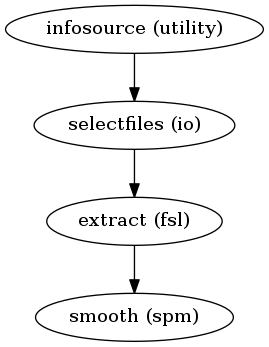

In [44]:
# preproc.write_graph(graph2use='colored', format='png', simple_form=True)
preproc.write_graph(graph2use='flat', format='png', simple_form=True)

# Visualize the graph
from IPython.display import Image
Image(filename=opj(preproc.base_dir, 'preproc', 'graph.png'))

### checking different smooth methods

fslmath

In [10]:
smooth_img = nib.load('/output/smooth/preproc/sub-06/sub-06_task-tsl_run-1_fwhm-8_bold_smooth.nii.gz')

In [11]:
header = smooth_img.header
header.get_zooms()

(2.4, 2.4, 3.12, 2.0)

In [12]:
print(header.get_data_shape())

(81, 96, 63, 242)


spm 

In [16]:
img_path = '/output/smooth_nomask/preproc/sub-06/sub-06_task-tsl_run-1_fwhm-8_bold.nii'
smooth_img = nib.load(img_path)

In [7]:
img_path = '/output/smooth/preproc/sub-29/ssub-29_task-tsl_run-3_fwhm-8_bold_masked.nii'
smooth_img = nib.load(img_path)

In [17]:
header = smooth_img.header
header.get_zooms()

(2.4, 2.4, 3.12, 0.0)

In [18]:
print(header.get_data_shape())

(81, 96, 63, 242)


In [14]:
from nilearn.plotting import plot_anat, plot_epi, plot_img
import numpy as np
import nibabel as nb
import matplotlib.pyplot as plt

# Let's create a short helper function to plot 3D NIfTI images
def plot_slice(fname):

    # Load the image
    img = nb.load(fname)
    data = img.get_data()

    # Cut in the middle of the brain
    cut = int(data.shape[-2]/2) - 15

    # Plot the data
    plt.imshow(np.rot90(data[..., cut, 0]), cmap="gray")
    plt.gca().set_axis_off()

/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  # This is added back by InteractiveShellApp.init_path()


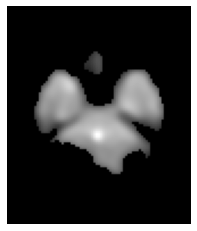

In [15]:
plot_slice(img_path)